# Baseline model

Split the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
from xverse.feature_subset import SplitXY

def splitXY(df, target_column):

    clf = SplitXY([target_column]) #Split the dataset into X and y
    X, y = clf.fit_transform(df) #returns features (X) dataset and target(Y) as a numpy array
    return X, y

def make_train_test_split(X=None, y=None, test_size=0.3, random_state=1234):

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [4]:
selected_vars = ['V11', 'V12', 'V3', 'V19', 'V7', 'V14', 'V1', 'V4', 'V21', 'V2', 'V18', 'V16', 'V17', 'V9', 'V10']

# Build logistic regression model

In [5]:
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [6]:
def build_model(X, y):
    
    clf = LogisticRegression()
    clf.fit(X, y)
    return clf

In [7]:
def evaluate_model(clf, X, y):
    
    pred = clf.predict(X) #predicted classes
    accuracy = accuracy_score(pred,y) # calculate accuracy
    fpr, tpr, _ = roc_curve(y, clf.predict_proba(X)[:,1]) # roc_curve
    auc_value = auc(fpr,tpr) # auc_value
    report = classification_report(y, pred, labels=[0,1], output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df = report_df.reset_index()
    model_eval  = report_df[report_df['index'].str.contains('1')][['precision','recall','f1-score']]
    model_eval['accuracy']  = list(report_df[report_df['index'].str.contains('accuracy')]['support'])
    model_eval['ROC']  = auc_value
    cf_matrix = confusion_matrix(y, pred)
    
    return model_eval, cf_matrix

In [8]:
def model_eval_data(clf, X_train, y_train, 
                         X_test, y_test, 
                         model_eval_train, 
                         model_eval_test,
                         Name=None):
    
    temp_eval_train, cf_matrix_train = evaluate_model(clf, X_train, y_train)
    temp_eval_test, cf_matrix_test = evaluate_model(clf, X_test, y_test)
    temp_eval_train.index = [Name]
    temp_eval_test.index = [Name]
    
    try:
        model_eval_train = model_eval_train.append(temp_eval_train)
        model_eval_test = model_eval_test.append(temp_eval_test)
    except:
        model_eval_train = temp_eval_train
        model_eval_test = temp_eval_test
    
    return model_eval_train, model_eval_test, cf_matrix_train, cf_matrix_test

In [9]:
def make_confusion_matrix_chart(cf_matrix_train, cf_matrix_test):
    
    plt.figure(1, figsize=(10,5))

    plt.subplot(121)
    sns.heatmap(cf_matrix_train, annot=True, yticklabels=['Not Fraud', 'Fraud'], 
                                xticklabels=['Not Fraud', 'Fraud'], fmt='g')
    plt.ylabel("Actual")
    plt.xlabel("Pred")
    plt.ylim([0,2])
    plt.title('Train data')

    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, yticklabels=['Not Fraud', 'Fraud'], 
                                xticklabels=['Not Fraud', 'Fraud'], fmt='g')
    plt.ylabel("Actual")
    plt.xlabel("Pred")
    plt.ylim([0,2])
    plt.tight_layout()
    plt.title('Test data')

    plt.tight_layout()
    return None

In [10]:
model_eval_train = pd.DataFrame({},[])
model_eval_test = pd.DataFrame({},[])

Using imbalanced data

In [11]:
X, y = splitXY(df, 'Class')
X_train, X_test, y_train, y_test = make_train_test_split(X=X, y=y, test_size=0.3, random_state=1)

In [12]:
X_train = X_train[selected_vars] #select the variables from variable selection proces
X_test = X_test[selected_vars]

In [13]:
clf = build_model(X_train, y_train)

In [14]:
model_eval_train, model_eval_test, cf_matrix_train, cf_matrix_test = model_eval_data(clf, X_train, y_train, 
                                                         X_test, y_test, 
                                                         model_eval_train, 
                                                         model_eval_test,
                                                         Name='imbalanced data - LogisticRegression')

In [15]:
model_eval_train

,precision,recall,f1-score,accuracy,ROC
imbalanced data - LogisticRegression,0.897638,0.638655,0.746318,0.999223,0.974718


In [16]:
model_eval_test

,precision,recall,f1-score,accuracy,ROC
imbalanced data - LogisticRegression,0.846154,0.57037,0.681416,0.999157,0.96878


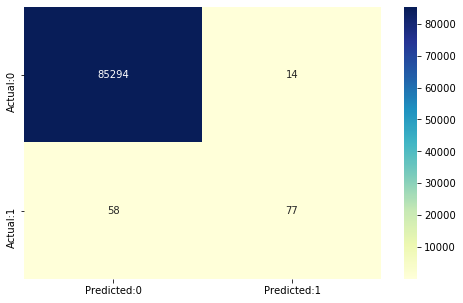

In [17]:
from sklearn.metrics import confusion_matrix
%matplotlib inline

y_pred = clf.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85308
           1       0.85      0.57      0.68       135

    accuracy                           1.00     85443
   macro avg       0.92      0.79      0.84     85443
weighted avg       1.00      1.00      1.00     85443



Change weight to 1:100

In [19]:
def build_model(X, y):
    
    weights = {0:1, 1:100}
    clf_cs1 = LogisticRegression(solver='lbfgs', class_weight=weights)
    clf_cs1.fit(X, y)
    return clf_cs1

In [20]:
clf_cs1 = build_model(X_train, y_train)

In [21]:
model_eval_train, model_eval_test, cf_matrix_train, cf_matrix_test = model_eval_data(clf_cs1, X_train, y_train, 
                                                         X_test, y_test, 
                                                         model_eval_train, 
                                                         model_eval_test,
                                                         Name='imbalanced data - LogisticRegression + CostSensitive')

In [22]:
model_eval_test

,precision,recall,f1-score,accuracy,ROC
imbalanced data - LogisticRegression,0.846154,0.570370,0.681416,0.999157,0.968780
imbalanced data - LogisticRegression + CostSensitive,0.303763,0.837037,0.445759,0.996711,0.979274


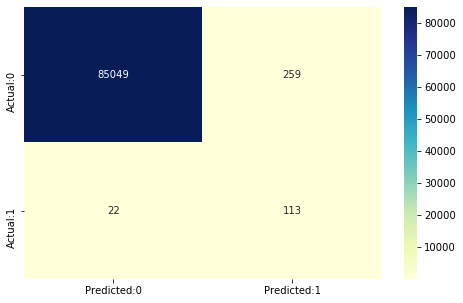

In [32]:
from sklearn.metrics import confusion_matrix
%matplotlib inline

y_pred = clf_cs1.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85308
           1       0.85      0.57      0.68       135

    accuracy                           1.00     85443
   macro avg       0.92      0.79      0.84     85443
weighted avg       1.00      1.00      1.00     85443



Calculate the class weight

In [25]:
from sklearn.utils.class_weight import compute_class_weight

In [26]:
weighting = compute_class_weight('balanced', [0,1], y)
weighting

C:\anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0, 1], y=[0 0 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


array([  0.50086524, 289.43800813])

In [27]:
def build_model(X, y):
    
    weights = {0:0.5, 1:289}
    clf_cs2 = LogisticRegression(solver='lbfgs', class_weight=weights)
    clf_cs2.fit(X, y)
    return clf_cs2

In [28]:
clf_cs2 = build_model(X_train, y_train)

In [29]:
model_eval_train, model_eval_test, cf_matrix_train, cf_matrix_test = model_eval_data(clf_cs2, X_train, y_train, 
                                                         X_test, y_test, 
                                                         model_eval_train, 
                                                         model_eval_test,
                                                         Name='imbalanced data - LogisticRegression + CostSensitvie(with proper weight)')

In [30]:
model_eval_test

,precision,recall,f1-score,accuracy,ROC
imbalanced data - LogisticRegression,0.846154,0.570370,0.681416,0.999157,0.968780
imbalanced data - LogisticRegression + CostSensitive,0.303763,0.837037,0.445759,0.996711,0.979274
imbalanced data - LogisticRegression + CostSensitvie(with proper weight),0.070952,0.866667,0.131166,0.981859,0.981485


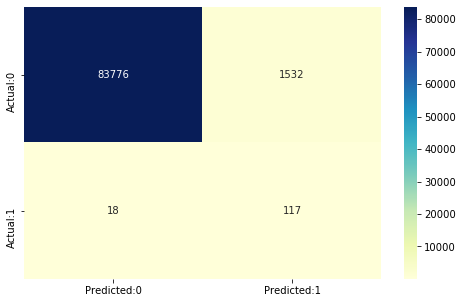

In [33]:
from sklearn.metrics import confusion_matrix
%matplotlib inline

y_pred = clf_cs2.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")